# Tutorial 6a: Model selection

(c) 2016 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](t6a_model_selection.ipynb). You can also view it [here](https://nbviewer.jupyter.org/url/bebi103.caltech.edu/2016/tutorials/t6a_model_selection.ipynb).*

In [1]:
import collections
import itertools
import math

import numpy as np
import numba
import pandas as pd
import scipy.optimize
import scipy.stats as st
import statsmodels.tools.numdiff as smnd

import emcee
import corner
import bebi103

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
%matplotlib inline

## Model selection for the Good, et al. data

Recall from [Tutorial 3a](t3a_parameter_estimation_by_optimization.html) that we were considering two different theoretical models for the spindle length vs. droplet size data presented in Good, et al.

#### Model A

In Model A, the spindle size is independent of droplet size.  The corresponding equation is

\begin{align}
l = \theta.
\end{align}

We assume the data are Gaussian distributed about this $\theta$, which an unknown variance $\sigma$.

#### Model B

We define by Model B the full relation between spindle length and droplet diameter,

\begin{align}
l(d;\gamma,\theta) \approx \frac{\gamma d}{\left(1+(\gamma d/\theta)^3\right)^{\frac{1}{3}}}.
\end{align}

As in Model A, we assume the data are Gaussian distributed about this $\theta$, which an unknown variance $\sigma$.

### The odds ratio
As given in [lecture 4](http://bebi103.caltech.edu/2016/lecture_notes/l04_model_selection.pdf), the approximate odds ratio is

\begin{align}
O_{AB} \approx \left(\frac{P(A\mid I)}{P(B\mid I)}\right)
\left(\frac{P(D\mid \theta^*, \sigma^*, A, I)}{P(D\mid \theta^*, \gamma^*, \sigma^*, B, I)}\right)
\left(\frac{P(\theta^*, \sigma^* \mid A, I) \,2\pi\,\sqrt{\det\boldsymbol{\sigma_A^2}}}
{P(\theta^*, \gamma^*, \sigma^*\mid B, I)\,(2\pi)^{3/2} \sqrt{\det\boldsymbol{\sigma}_B^2}}\right),
\end{align}

where the asterisks denote the most probable parameter values (the MAP), and $\boldsymbol{\sigma}_i$ is the covariance matrix computed for Model $i$.  So, to compute the odds ratio, we need to first specify the prior odds of the two models.  We will assume that

\begin{align}
\frac{P(A\mid I)}{P(B\mid I)} \approx 1,
\end{align}

since we are not sure which model is correct *a priori* (that was the whole purpose of the experiment).  We also need to specify the respective priors.  We will assume that $\theta$, $\gamma$, and $\sigma$ are all independent.  Further, since $\theta$ and $\sigma$ represent the same thing in Model A and in Model B, we assume $P(\theta, \sigma \mid A, I) = P(\theta, \sigma \mid B, I)$.  Finally, we know that $0 \le \gamma \le 1$ by physical considerations.  We will take a uniform prior for $P(\gamma\mid B, I)$, so the ratio

\begin{align}
\frac{P(\theta^*, \sigma^*\mid A, I)}
{P(\theta^*, \gamma^*, \sigma^*\mid B, I)} = 1.
\end{align}

All we have left to do is to compute the MAP and the covariance at the MAP for each model, and then to evaluate the likelihood at the MAP.  So, we will first define the likelihoods for both models.

In [Tutorial 3a](t3a_parameter_estimation_by_optimization.html), we found the MAP and covariance for both Model A and Model B.  The problem, though if that we always worked with the marginalized posterior, where $\sigma$, the error in the data, was eliminated from the problem.  Here, we need to find $\sigma^*$, the most probable variance in the data, and use that in computing the (unmarginalized) likelihood.  There is an analytical solution for Model A, but we will just compute both MAPs using `scipy.optimize.minimize()`.  We'll start by defining the functions we need, first for Model A.  Note that our array of parameters, `p`, now has `sigma` in it.  As a reminder, if $l(d;\mathbf{a})$ is the theoretically predicted spindle length for a droplet of diameter $d$ depending on parameters $\mathbf{a}$, the likelihood is

\begin{align}
P(\{d_i, l_i\}\mid \mathbf{a}, M, I) = \prod_i \frac{1}{\sqrt{2\pi \sigma^2}}\,
\exp\left\{-\frac{(l_i - l(d_i, \mathbf{a})^2}{2\sigma^2}\right\}.
\end{align}

In [2]:
def spindle_length(p, d, model):
    """
    Theoretical models for spindle length.
    """
    if model == 'A':
        return p[0] * np.ones_like(d)
    elif model == 'B':
        theta, gamma, _ = p
        return gamma * d / np.cbrt(1 + (gamma * d / theta)**3)
    else:
        raise RuntimeError('Model not properly specified.')

        
def resid(p, d, ell, model):
    """
    Residuals for spindle length model.
    """
    return ell - spindle_length(p, d, model)


def log_likelihood(p, d, ell, model):
    """
    Log likelihood for mitotic spindle length vs droplet size.
    """
    sigma = p[-1]
    
    return -np.sum(resid(p, d, ell, model)**2) / 2 / sigma**2 \
                - len(ell) / 2 * np.log(2 * np.pi * sigma**2)
    
def log_prior(p, model):
    """
    Log prior for mitotic spindle length vs droplet size.
    """
    if (p < 0).any():
        return -np.inf

    if model == 'B' and p[1] > 1:
        return -np.inf

    return -np.log(p[-1])


def log_posterior(p, d, ell, model):
    """
    Log posterior for mitotic spindle length vs droplet size.
    Model A:
        p[0] = theta
        p[1] = sigma
    Model B:
        p[0] = theta
        p[1] = gamma
        p[2] = sigma    
    """
    lp = log_prior(p, model)
    
    if lp == -np.inf:
        return -np.inf
    
    return lp + log_likelihood(p, d, ell, model)


def neg_log_posterior(p, d, ell, model):
    return -log_posterior(p, d, ell, model)

We can now proceed with MAP finding using Powell's method.

In [3]:
# Load data into DataFrame
df = pd.read_csv('../data/good_invitro_droplet_data.csv', comment='#')

# Extra arguments as a tuple
args = (df['Droplet Diameter (um)'], df['Spindle Length (um)'])

# Model A
p0 = np.array([40.0, 5.0])
args_A = args + ('A',)
res = scipy.optimize.minimize(neg_log_posterior, p0, args=args_A, 
                              method='powell')
popt_A = res.x
cov_A = -np.linalg.inv(smnd.approx_hess(popt_A, log_posterior, args=args_A))

# Model B
p0 = np.array([40, 0.5, 5])
args_B = args + ('B',)
res = scipy.optimize.minimize(neg_log_posterior, p0, args=args_B, 
                              method='powell')
popt_B = res.x
cov_B = -np.linalg.inv(smnd.approx_hess(popt_B, log_posterior, args=args_B))

/Users/Justin/anaconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Just as a reminder, let's plot our best-fit results.

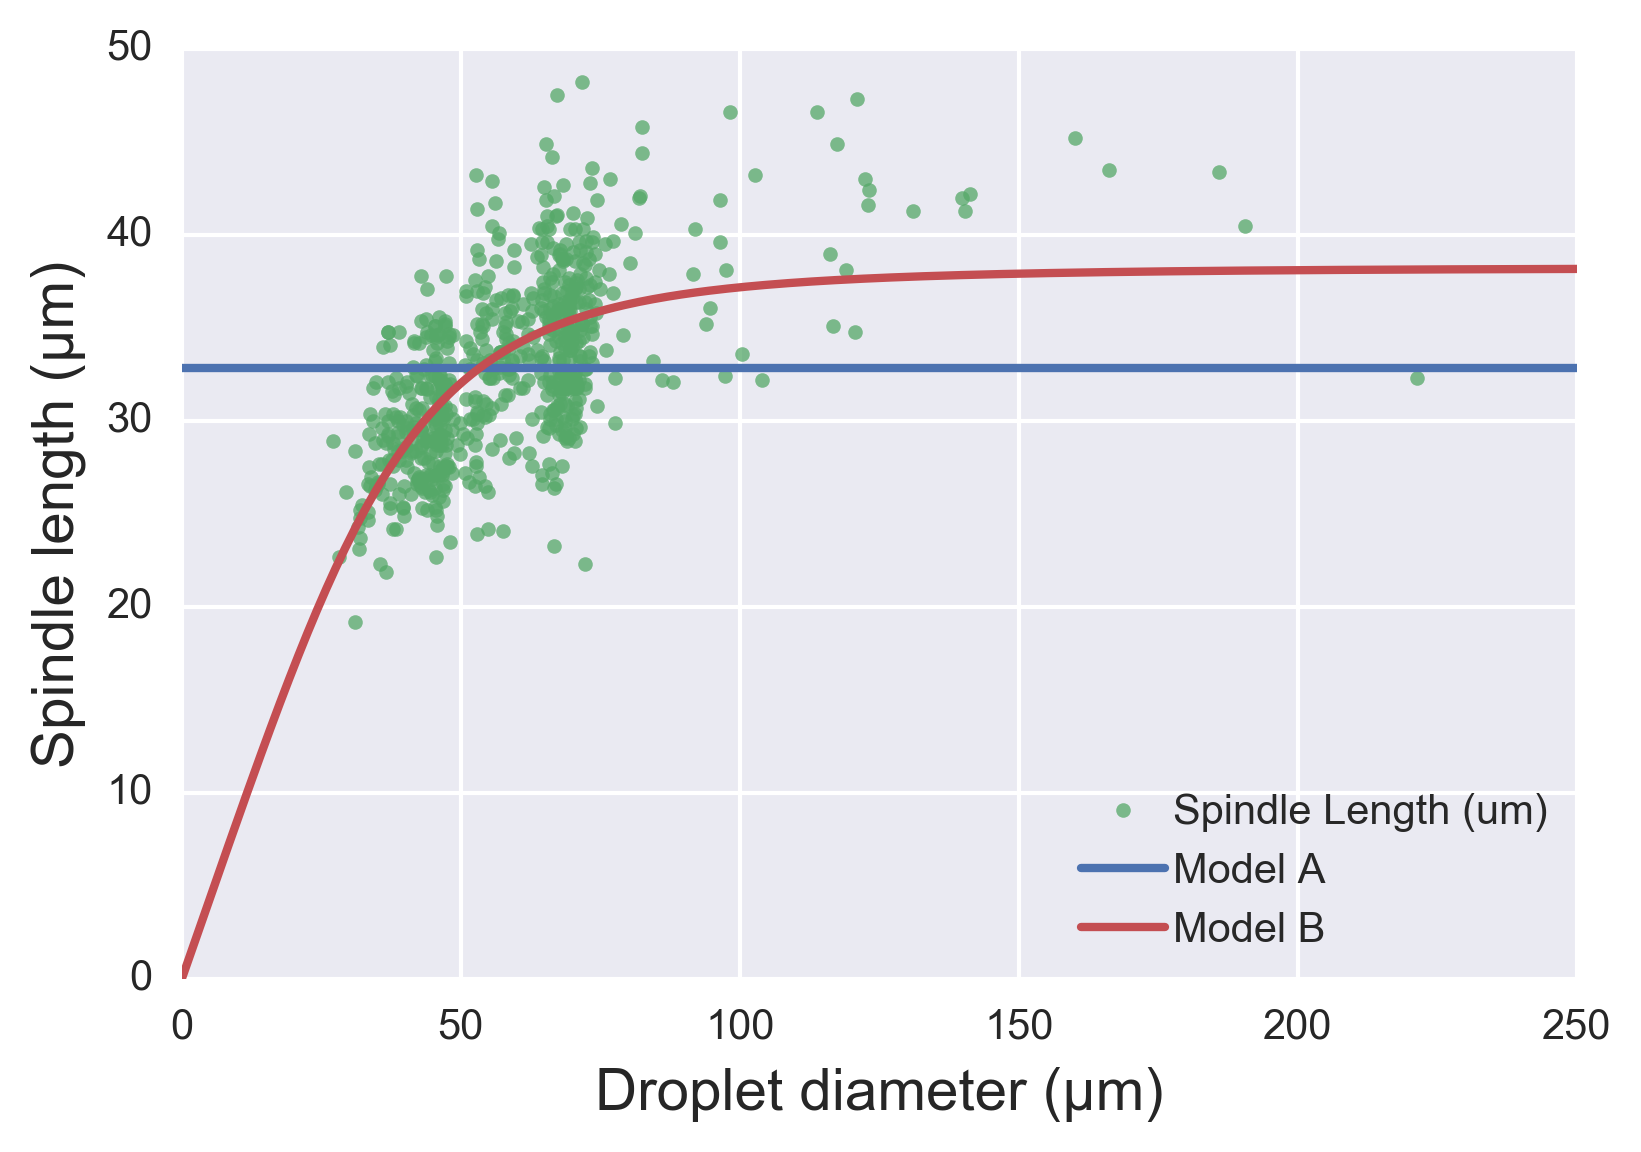

In [4]:
# Smooth droplet diameter for plotting
d_plot = np.linspace(0, 250, 300)

# Plot data and curves
plt.plot(df['Droplet Diameter (um)'], df['Spindle Length (um)'], '.', 
         alpha=0.75, color=sns.color_palette()[1])
plt.plot(d_plot, spindle_length(popt_A, d_plot, 'A'), '-',
         color=sns.color_palette()[0], label='Model A')
plt.plot(d_plot, spindle_length(popt_B, d_plot, 'B'), '-',
        color=sns.color_palette()[2], label='Model B')

# Labels
plt.xlabel('Droplet diameter (µm)')
plt.ylabel('Spindle length (µm)')
plt.legend(loc='lower right');

We can now compute the components of the odds ratio.  As is often good practice, we will compute the log odds ratio.  We will do it piece by piece.  As we already established, the prior ratio is unity.  Now, let's look at the goodness of fit ratio.

In [5]:
log_good_fit_ratio = log_likelihood(popt_A, *args_A) - \
                                    log_likelihood(popt_B, *args_B)

print('Goodness of fit ratio:', np.exp(log_good_fit_ratio))

Goodness of fit ratio: 3.078166469e-71


Wow.  Model A really gives a lousy fit to the data compared to model B.  Now, let's see if the Occam factor ratio can overwhelm this bad goodness of fit.  Remember that a model with fewer parameters, like Model A, has a bigger Occam factor, making it more probable.

In [6]:
log_occam_factor = (-np.log(2 * np.pi) + np.log(np.linalg.det(cov_A)) 
                    - np.log(np.linalg.det(cov_B))) / 2

print('Occam factor ratio:', np.exp(log_occam_factor))

Occam factor ratio: 22.4341731335


Yes, the Occam factor penalizes Model B, but nowhere near enough to compensate for the superior goodness of fit it provides.  So, we can compute approximate odds ratio as follows.

In [7]:
log_odds_ratio = log_good_fit_ratio + log_occam_factor

print('Odds ratio:', np.exp(log_odds_ratio))

Odds ratio: 6.90561194994e-70


Ya, Model B is waaaaay more probable than Model A!

## Model selection of the Singer, et al. data

Now, we'll turn to model selection of the Singer, et al. data from [Tutorial 4a](t4a_param_est_mle.html).  As a reminder, Singer and coworkers used single molecule FISH to get mRNA transcript counts of four different genes in each cell in a population of mouse embryonic stem cells.  The distribution of mRNA counts in a given cell is expected to be Negative Binomially distributed.

\begin{align}
P(n\mid r, p) = \frac{\Gamma(n+r)}{n!\,\Gamma(r)}\,p^{r}(1-p)^{n}.
\end{align}

If there are two different cell types that express the gene differently, the distribution is a linear combination of negative binomials,

\begin{align}
P(n\mid r_1, p_1, r_2, p_2, f) = 
f\,\frac{\Gamma(n+r_1)}{n!\,\Gamma(r_1)}\,p_1^{r_1}(1-p_1)^{n}
+ (1-f) \frac{\Gamma(n + r_2)}{n!\,\Gamma(r_2)}\,p_2^{r_2}(1-p_2)^{n}.
\end{align}

We can look at how the data are distributed by looking at their ECDFs.

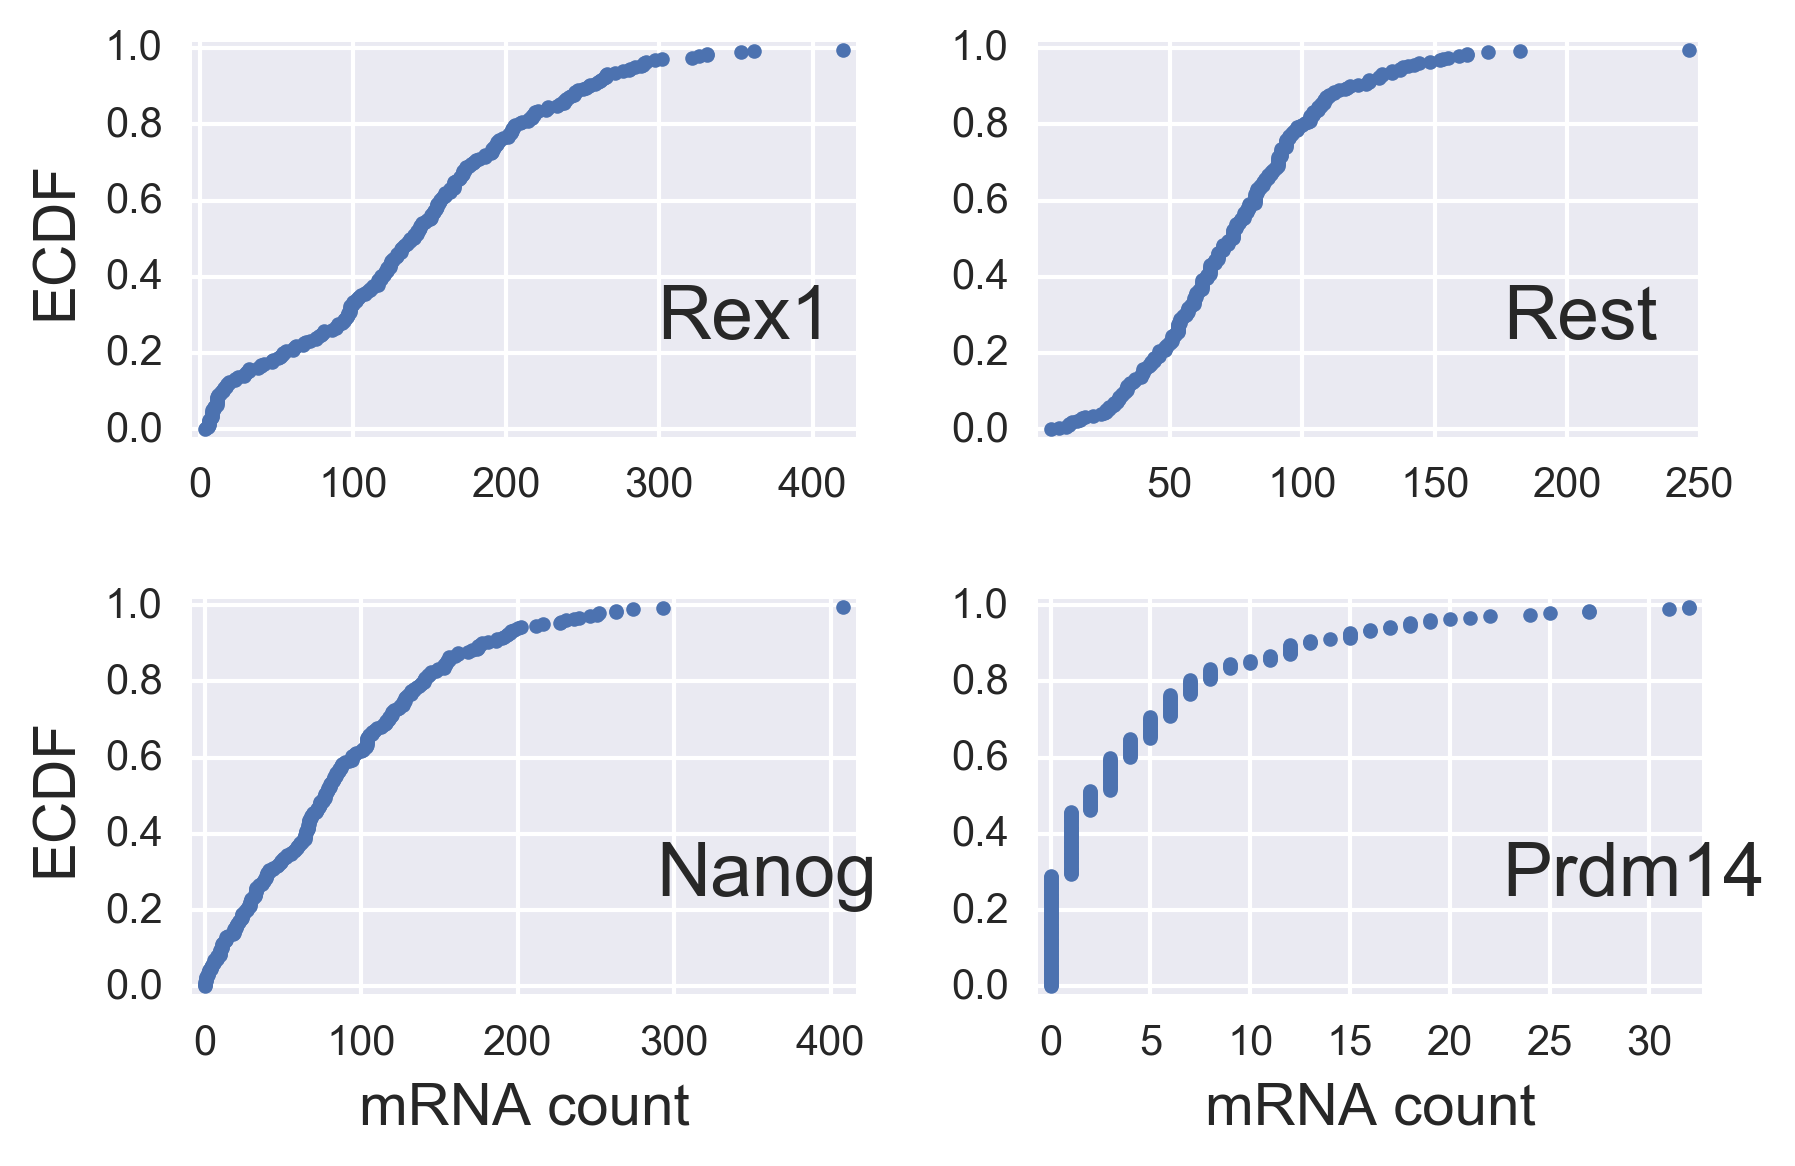

In [8]:
# Load DataFrame
df = pd.read_csv('../data/singer_transcript_counts.csv', comment='#')

# Make plots of ECDFs
fig, ax = plt.subplots(2, 2)
sp_inds = list(itertools.product([0,1], [0,1]))

for i, gene in enumerate(df.columns):
    # Build ECDF
    y = np.arange(len(df[gene])) / len(df[gene])
    x = np.sort(df[gene].values)
    
    # Plot
    ax[sp_inds[i]].plot(x, y, '.')
    ax[sp_inds[i]].text(0.7, 0.25, gene, transform=ax[sp_inds[i]].transAxes,
                       fontsize=18)
    ax[sp_inds[i]].margins(0.02)
    
# Clean up
for i in [0,1]:
    ax[1,i].set_xlabel('mRNA count')
    ax[i,0].set_ylabel('ECDF')
plt.tight_layout(w_pad=2, h_pad=2)

Our goal here is to decide which of these distributions is more probable for each of the four genes that were measured.  We will define Model 1 to be a single negative binomial distribution and Model 2 to be a double negative binomial.  The approximate odds ratio is

\begin{align}
\left(\frac{P(A\mid I)}{P(B\mid I)}\right)
\left(\frac{P(D\mid r^*, p^*, M_1, I)}{P(D\mid r_1^*, p_1^*, r_2^*, p_2^*, f^*, M_2, I)}\right)
\left(\frac{P(r^*, p^* \mid M_1, I) \,2\pi\,\sqrt{\det\boldsymbol{\sigma_1^2}}}
{P(r_1^*, p_1^*, r_2^*, p_2^*, f^*\mid M_2, I)\,(2\pi)^{5/2} \sqrt{\det\boldsymbol{\sigma}_2^2}}\right).
\end{align}


Since we don't have a preference for either model a priori, we we will take $P(M_1\mid I) \approx P(M_2\mid I)$.  We will take uniform priors for $p$, $p_1$, and $p_2$ on the interval $[0,1]$.  Similarly, we will take $f$ to have a uniform prior on $[0,1]$.  We will take uniform priors for $r$, $r_1$, and $r_2$ on the interval $[0, r_\mathrm{max}]$, where $r_\mathrm{max}$ is the most bursts we would expect during an mRNA lifetime.  We will investigate this parameter at the end of our analysis.  For now, we can say that

\begin{align}
\frac{P(r^*, p^* \mid M_1, I)}{P(r_1^*, p_1^*, r_2^*, p_2^*, f^*\mid M_2, I)}
= r_\mathrm{max}.
\end{align}

So now, we just need to find the MAPs for each model and evaluate the goodness of fit ratio and the ratio of determinants of the covariances.

For this example, we'll use MCMC to find the MAPs and compute covariances, since the optimization/Hessian calculation is numerically challenging. Note that we could use PTMCMC and compute the odds ratio without making approximations about the posterior, but this is more computationally intensive (and we will do it in [the following tutorial](t6b_ptmcmc.html)). 

For Model 2, we sum two quantities and then take the logarithm.  This could be a problem if `st.nbinom.pmf()` returns very small values.  In this case, we essentially get a log of zero, which will give $-\infty$ for the log likelihood.  We need to avoid this issue.  We would like to use only the `st.nbinom.logpmf()` function.  To do this, we need to re-write our likelihood.  Let 

\begin{align}
\xi_1 &= \ln\left(\frac{\Gamma(n+r_1)}{n!\,\Gamma(r_1)}\,p_1^{r_1}(1-p_1)^{n}\right),\\[1em]
\text{and } \xi_2 &= \ln\left(\frac{\Gamma(n+r_2)}{n!\,\Gamma(r_2)}\,p_2^{r_2}(1-p_2)^{n}\right).
\end{align}

Here, $\xi_1$ and $\xi_2$ are what is returned by `st.nbinom.logpmf()` (though we will write our own function using Numba to give the log PMF for speed). Then,

\begin{align}
P(n\mid r_1, p_1, r_2, p_2, f) = f \mathrm{e}^{\xi_1} + (1-f)\mathrm{e}^{\xi_2} 
= \mathrm{e}^{\xi_1 + \ln f} + \mathrm{e}^{\xi_2 + \ln(1-f)}.
\end{align}

So, we can compute the log likelihood as the log of a sum of exponentials.

\begin{align}
\ln (n\mid r_1, p_1, r_2, p_2, f) = \ln\left(\mathrm{e}^{\xi_1 + \ln f} + \mathrm{e}^{\xi_2 + \ln(1-f)}\right).
\end{align}

We start by coding up the functions we need. From [Tutorial 4b](t4b_param_est_with_mcmc.html), we saw that speed matters. So, we will JIT our functions. 

In [10]:
@numba.vectorize([numba.float64(numba.float64)],nopython=True)
def lngamma(x):
    """
    Log of Gamma function.
    """
    if x < 0.0:
        return 0.0
    return math.lgamma(x)


@numba.jit(nopython=True)
def nbinom_logpmf(n, r, p):
    """
    Negative binomial PMF evaluated a n-values for a given r, p.
    """
    return lngamma(n+r) - lngamma(n+1) - lngamma(r) \
                    + n * np.log(1-p) + r * np.log(p)

    
@numba.jit(nopython=True)
def double_nbinom_logpmf(n, r1, p1, r2, p2, f):
    """
    Double negative binomial PMF evaluated at n-values.
    """
    return np.logaddexp(nbinom_logpmf(n, r1, p1) + np.log(f),
                        nbinom_logpmf(n, r2, p2) + np.log(1-f))


@numba.jit(nopython=True)
def log_likelihood_1(params, n):
    """
    Log likelihood for negative binomial distributed parameters.
    """
    r, p = params
    return np.sum(nbinom_logpmf(n, r, p))


@numba.jit(nopython=True)
def log_likelihood_2(params, n):
    """
    Log likelihood for double negative binomial distributed parameters.
    """
    r1, p1, r2, p2, f = params
    return np.sum(double_nbinom_logpmf(n, r1, p1, r2, p2, f))

        
@numba.jit(nopython=True)        
def log_prior_1(params, r_max):
    """
    Log prior for negative binomially distributed bursty gene expression.
    """
    r, p = params
    # Zero probability of having p < 0 or p > 1
    if p < 0 or p > 1 or r <= 0 or r > r_max:
        return -np.inf
    return -np.log(r_max - 1)


@numba.jit(nopython=True)      
def log_prior_2(params, r_max):
    """
    Log prior for double negative binomially distributed bursty 
    gene expression.
    """
    r_1, p_1, r_2, p_2, f = params
    
    # All the things the could be wrong
    test = (f <= 0) or (f >= 1) or (r_1 <= 0) or (r_2 <= 0) or (p_1 < p_2) \
           or (p_2 < 0) or (p_1 > 1) or (r_1 > r_max) or (r_2 > r_max)

    if test:
        return -np.inf
    return -2 * np.log(r_max - 1)
        
    
@numba.jit(nopython=True)       
def log_posterior_1(params, n, r_max):
    """
    Log posterior for negative binomials.
    """
    lp = log_prior_1(params, r_max)
    if lp == -np.inf:
        return -np.inf
    
    return lp + log_likelihood_1(params, n)


@numba.jit(nopython=True)       
def log_posterior_2(params, n, r_max):
    """
    Log posterior for negative binomials.
    """
    lp = log_prior_2(params, r_max)
    if lp == -np.inf:
        return -np.inf
    
    return lp + log_likelihood_2(params, n)

We'll write a function to do the MCMC sampling for the respective models.  We will use the `run_ensemble_emcee()` method in the `bebi103` module for convenience.  A nicety with that module is that the traces are conveniently returned as Pandas `DataFrame`s.

In [11]:
def sample_mcmc(n, model, r_max=100, n_walkers=50, n_burn=10000, n_steps=10000):
    """
    Sample postrior using MCMC.
    """
    # Arguments for posterior
    args = (n, r_max)
    
    # Parameters and how we start them
    if model == 1:
        p_dict = collections.OrderedDict(
                [('r', (np.random.exponential, (1,))),
                 ('p', (np.random.uniform, (0, 1)))])

        return bebi103.run_ensemble_emcee(log_posterior_1, n_burn, n_steps,
                        n_walkers, p_dict=p_dict, args=args)
    elif model == 2:
        p_dict = collections.OrderedDict(
                [('r1', (np.random.exponential, (1,))),
                 ('p1', (np.random.uniform, (0, 1))),
                 ('r2', (np.random.exponential, (1,))),
                 ('p2', (np.random.uniform, (0, 1))),
                 ('f', (np.random.uniform, (0, 1)))])

        # Build p0; need to make sure p1 > p2
        p0 = np.empty((n_walkers, 5))
        for i, key in enumerate(p_dict):
            p0[:,i] = p_dict[key][0](*(p_dict[key][1] + (n_walkers,)))

        # Make sure p1 > p2
        p0[:,1], p0[:,3] = np.maximum(p0[:,1], p0[:,3]), \
                                np.minimum(p0[:,1], p0[:,3])
    
        return bebi103.run_ensemble_emcee(
            log_posterior_2, n_burn=n_burn, n_steps=n_steps,
            n_walkers=n_walkers, p0=p0, args=args, columns=p_dict.keys())

### Analysis for Rex1
Now, we'll load the data and do the calculation for the Rex1 gene, which we saw displayed qualitatively double-negative binomial behavior.

In [12]:
df = pd.read_csv('../data/singer_transcript_counts.csv', comment='#')

df_1 = sample_mcmc(df['Rex1'].values, 1)
df_2 = sample_mcmc(df['Rex1'].values, 2)

Now that we have the samples, we can pull out the MAP and compute the covariance matrix.  We can then use the MAP to compute the maximum likelihood.  Pulling out the MAPs is as we have done before with MCMC samples.  Note that the `DataFrame` containing the traces has the log posterior as its penultimate column and the chain number its last column, so we ignore those values.

In [13]:
# Pull out MAPs
max_ind = np.argmax(df_1['lnprob'].values)
popt_1 = df_1.loc[max_ind, ['r', 'p']]

max_ind = np.argmax(df_2['lnprob'].values)
popt_2 = df_2.loc[max_ind, ['r1', 'p1', 'r2', 'p2', 'f']]

# Show what we got
print('popt_1\n', popt_1, '\n')
print('popt_2\n', popt_2)

popt_1
 r    1.632797
p    0.011663
Name: 469370, dtype: float64 

popt_2
 r1    3.779645
p1    0.212673
r2    5.009253
p2    0.030026
f     0.158437
Name: 275323, dtype: float64


Referring back to [Tutorial 4a](t4a_param_est_mle.html), these are the same values we got by optimization for Rex1.  If we are approximating the posterior as Gaussian, we can just directly compute the covariance matrix from the traces.  We can use the `cov()` method of a `DataFrame` to do that.

In [14]:
# Compute covariance
cov_1 = np.cov(df_1.loc[:, ['r', 'p']].values.transpose())
cov_2 = np.cov(df_2.loc[:, ['r1', 'p1', 'r2', 'p2', 'f']].values.transpose())

We now have the pieces in hand to compute the odds ratio.  We'll start with the Occam factor ratio.  To estimate $r_\mathrm{max}$, we will refer to the excellent [BioNumbers website](http://bionumbers.hms.harvard.edu/).  The typical mRNA degradation time in mice, is [9 hours](http://bionumbers.hms.harvard.edu/bionumber.aspx?&id=106378).  A burst every half hour seems pretty fast to me, so we'll estimate $r_\mathrm{max} \approx 20$ and use this in our calculations. Remember, this penalizes the double-negative binomial model.

In [15]:
r_max = 20
log_occam_ratio = np.log(r_max) \
                + np.log(np.linalg.det(cov_1)) / 2 \
                - np.log(np.linalg.det(cov_2)) / 2 \
                - 1.5 * np.log(2 * np.pi)
                         
print('log occam ratio =', log_occam_ratio)

log occam ratio = 1.71873227522


So, the Occam factor penalizes the two-parameter model by a factor of about $\mathrm{e}^{4} \approx$ 50.  Now, we'll compute the goodness of fit.

In [16]:
log_good_fit_ratio = log_likelihood_1(popt_1.values, df['Rex1'].values) - \
    log_likelihood_2(popt_2.values, df['Rex1'].values)
    
print('log good fit ratio =', log_good_fit_ratio)

log good fit ratio = -48.310810205890675


The goodness of fit overwhelms the Occam factor, and the double negative binomial is far more likely.  Even a large $r_\mathrm{max}$ would not make the Occam factor ratio compete with the goodness of fit.  The final odd ratio is:

In [17]:
print('odds ratio = ', np.exp(log_good_fit_ratio + log_occam_ratio))

odds ratio =  5.8252913898e-21


The double negative binomial is overwhelmingly favored.

### Analysis for Prdm14
We will do the same analysis with Prdm14, which showed qualitatively single negative binomial behavior.

In [18]:
df_1 = sample_mcmc(df['Prdm14'].values, 1)
df_2 = sample_mcmc(df['Prdm14'].values, 2)

We proceed to continue the analysis as for Rex1.

In [19]:
# Pull out MAPs
max_ind = np.argmax(df_1['lnprob'].values)
popt_1 = df_1.loc[max_ind, ['r', 'p']]

max_ind = np.argmax(df_2['lnprob'].values)
popt_2 = df_2.loc[max_ind, ['r1', 'p1', 'r2', 'p2', 'f']]

# Show what we got
print('popt_1\n', popt_1, '\n')
print('popt_2\n', popt_2, '\n')

# Compute covariance
cov_1 = np.cov(df_1.loc[:, ['r', 'p']].values.transpose())
cov_2 = np.cov(df_2.loc[:, ['r1', 'p1', 'r2', 'p2', 'f']].values.transpose())

# Compute log Occam ratio
log_occam_ratio = np.log(r_max) \
                + np.log(np.linalg.det(cov_1)) / 2 \
                - np.log(np.linalg.det(cov_2)) / 2 \
                - 1.5 * np.log(2 * np.pi)
                         
print('log occam ratio =', log_occam_ratio)

# Goodness of fit ratio
log_good_fit_ratio = log_likelihood_1(popt_1.values, df['Prdm14'].values,) - \
                            log_likelihood_2(popt_2.values, df['Prdm14'].values)
    
print('log good fit ratio =', log_good_fit_ratio)

# Put it together
print('odds ratio = ', np.exp(log_good_fit_ratio + log_occam_ratio))

popt_1
 r    0.552888
p    0.108720
Name: 104452, dtype: float64 

popt_2
 r1    80.773943
p1     0.995819
r2     1.090371
p2     0.149225
f      0.293007
Name: 351387, dtype: float64 

log occam ratio = -2.0581769084
log good fit ratio = -1.358702832116819
odds ratio =  0.0328146656345


We got the same MAP as in Tutorial 3a for Model 1.  But we get a curious feature that the odds ratio is inconclusive; neither model is favored strongly.  Furthermore, the Occam factor ratio slightly favors the mode complicated double negative binomial model, even though we saw in Tutorial 3a that the number of transcripts of Prdm14 was unimodal.  What is up?

To check, let's look at our posteriors, first for model 1.

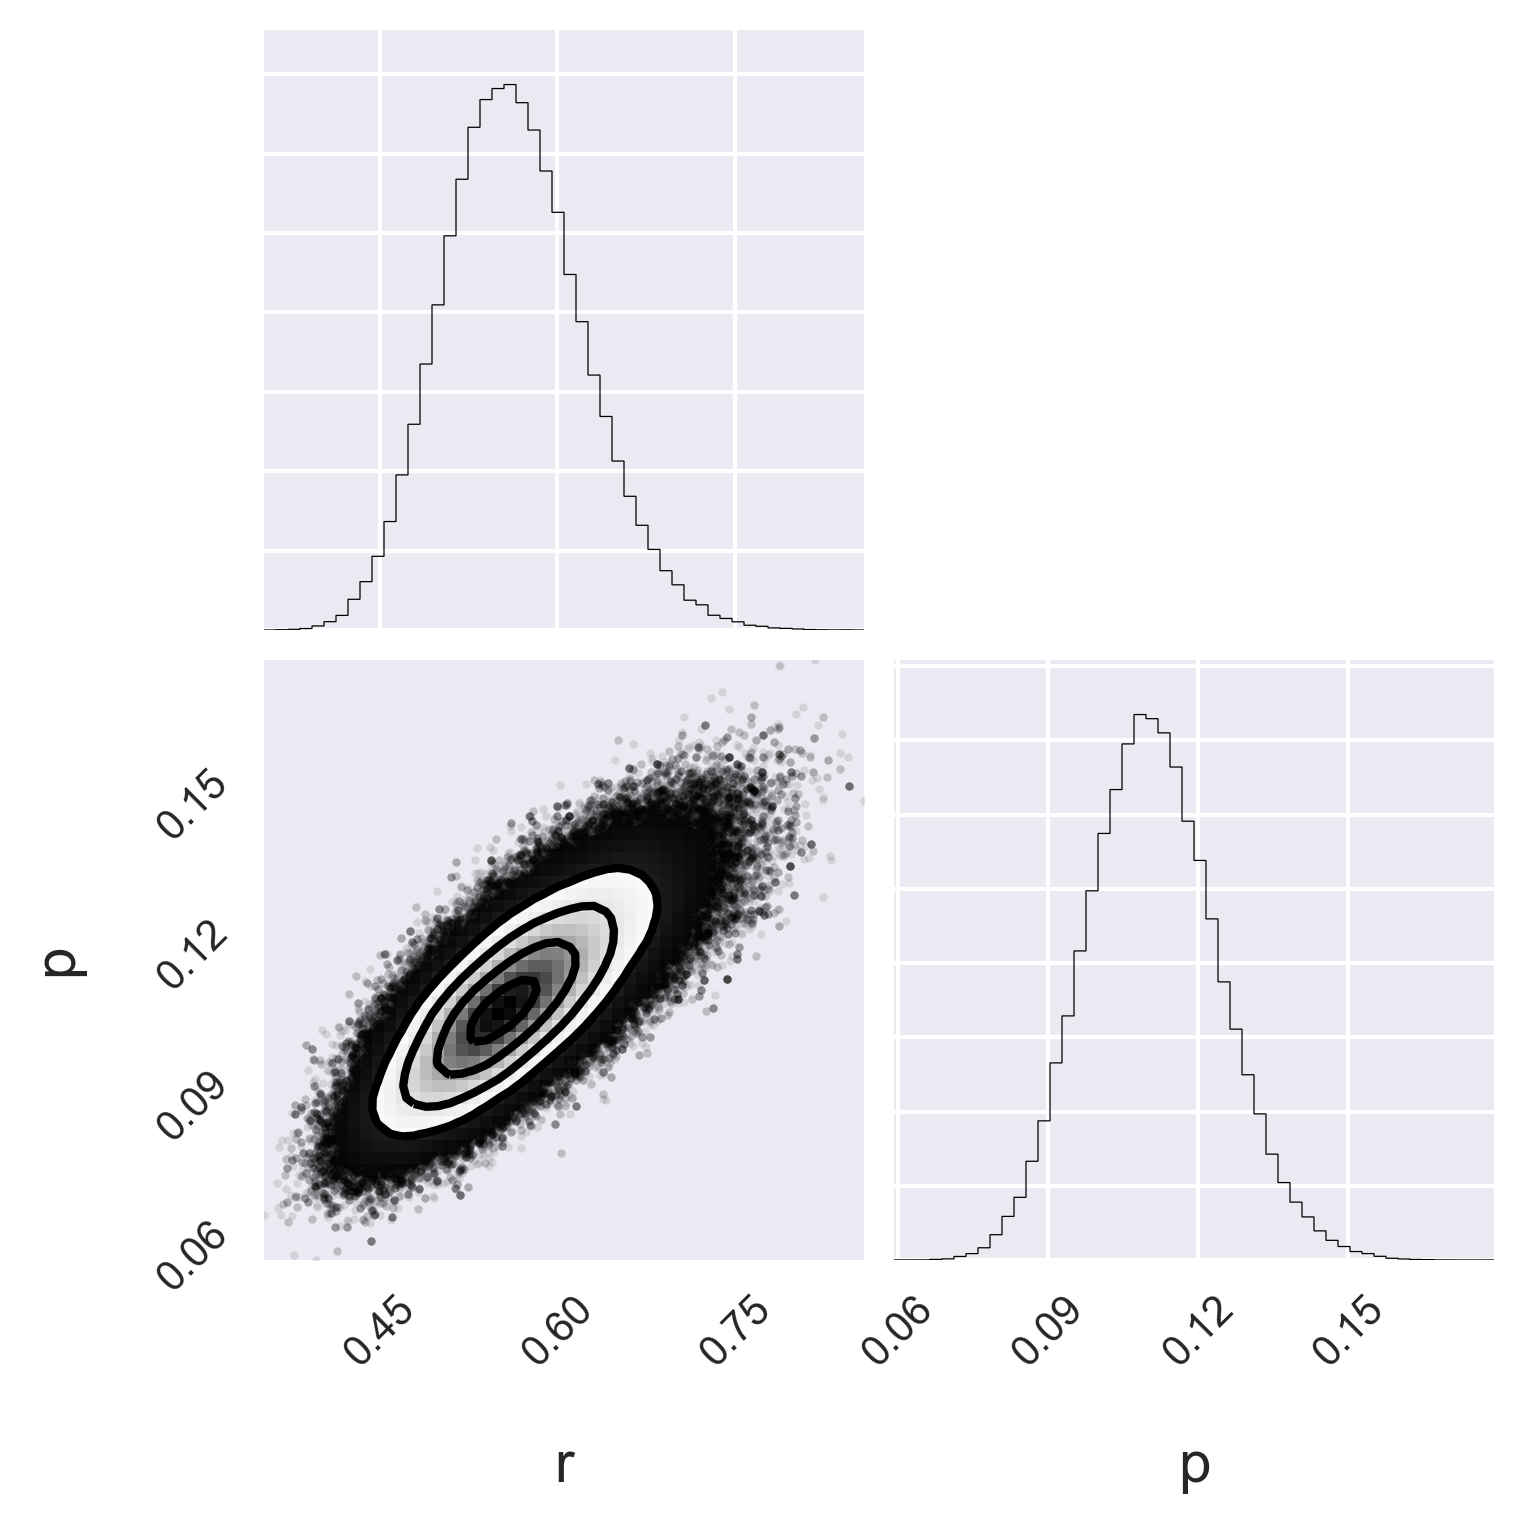

In [20]:
corner.corner(df_1[['r', 'p']], labels=['r', 'p'], bins=50, smooth=1);

This looks ok.  Things look roughly Gaussian.  Now let's look at the posteriors for Model 2.

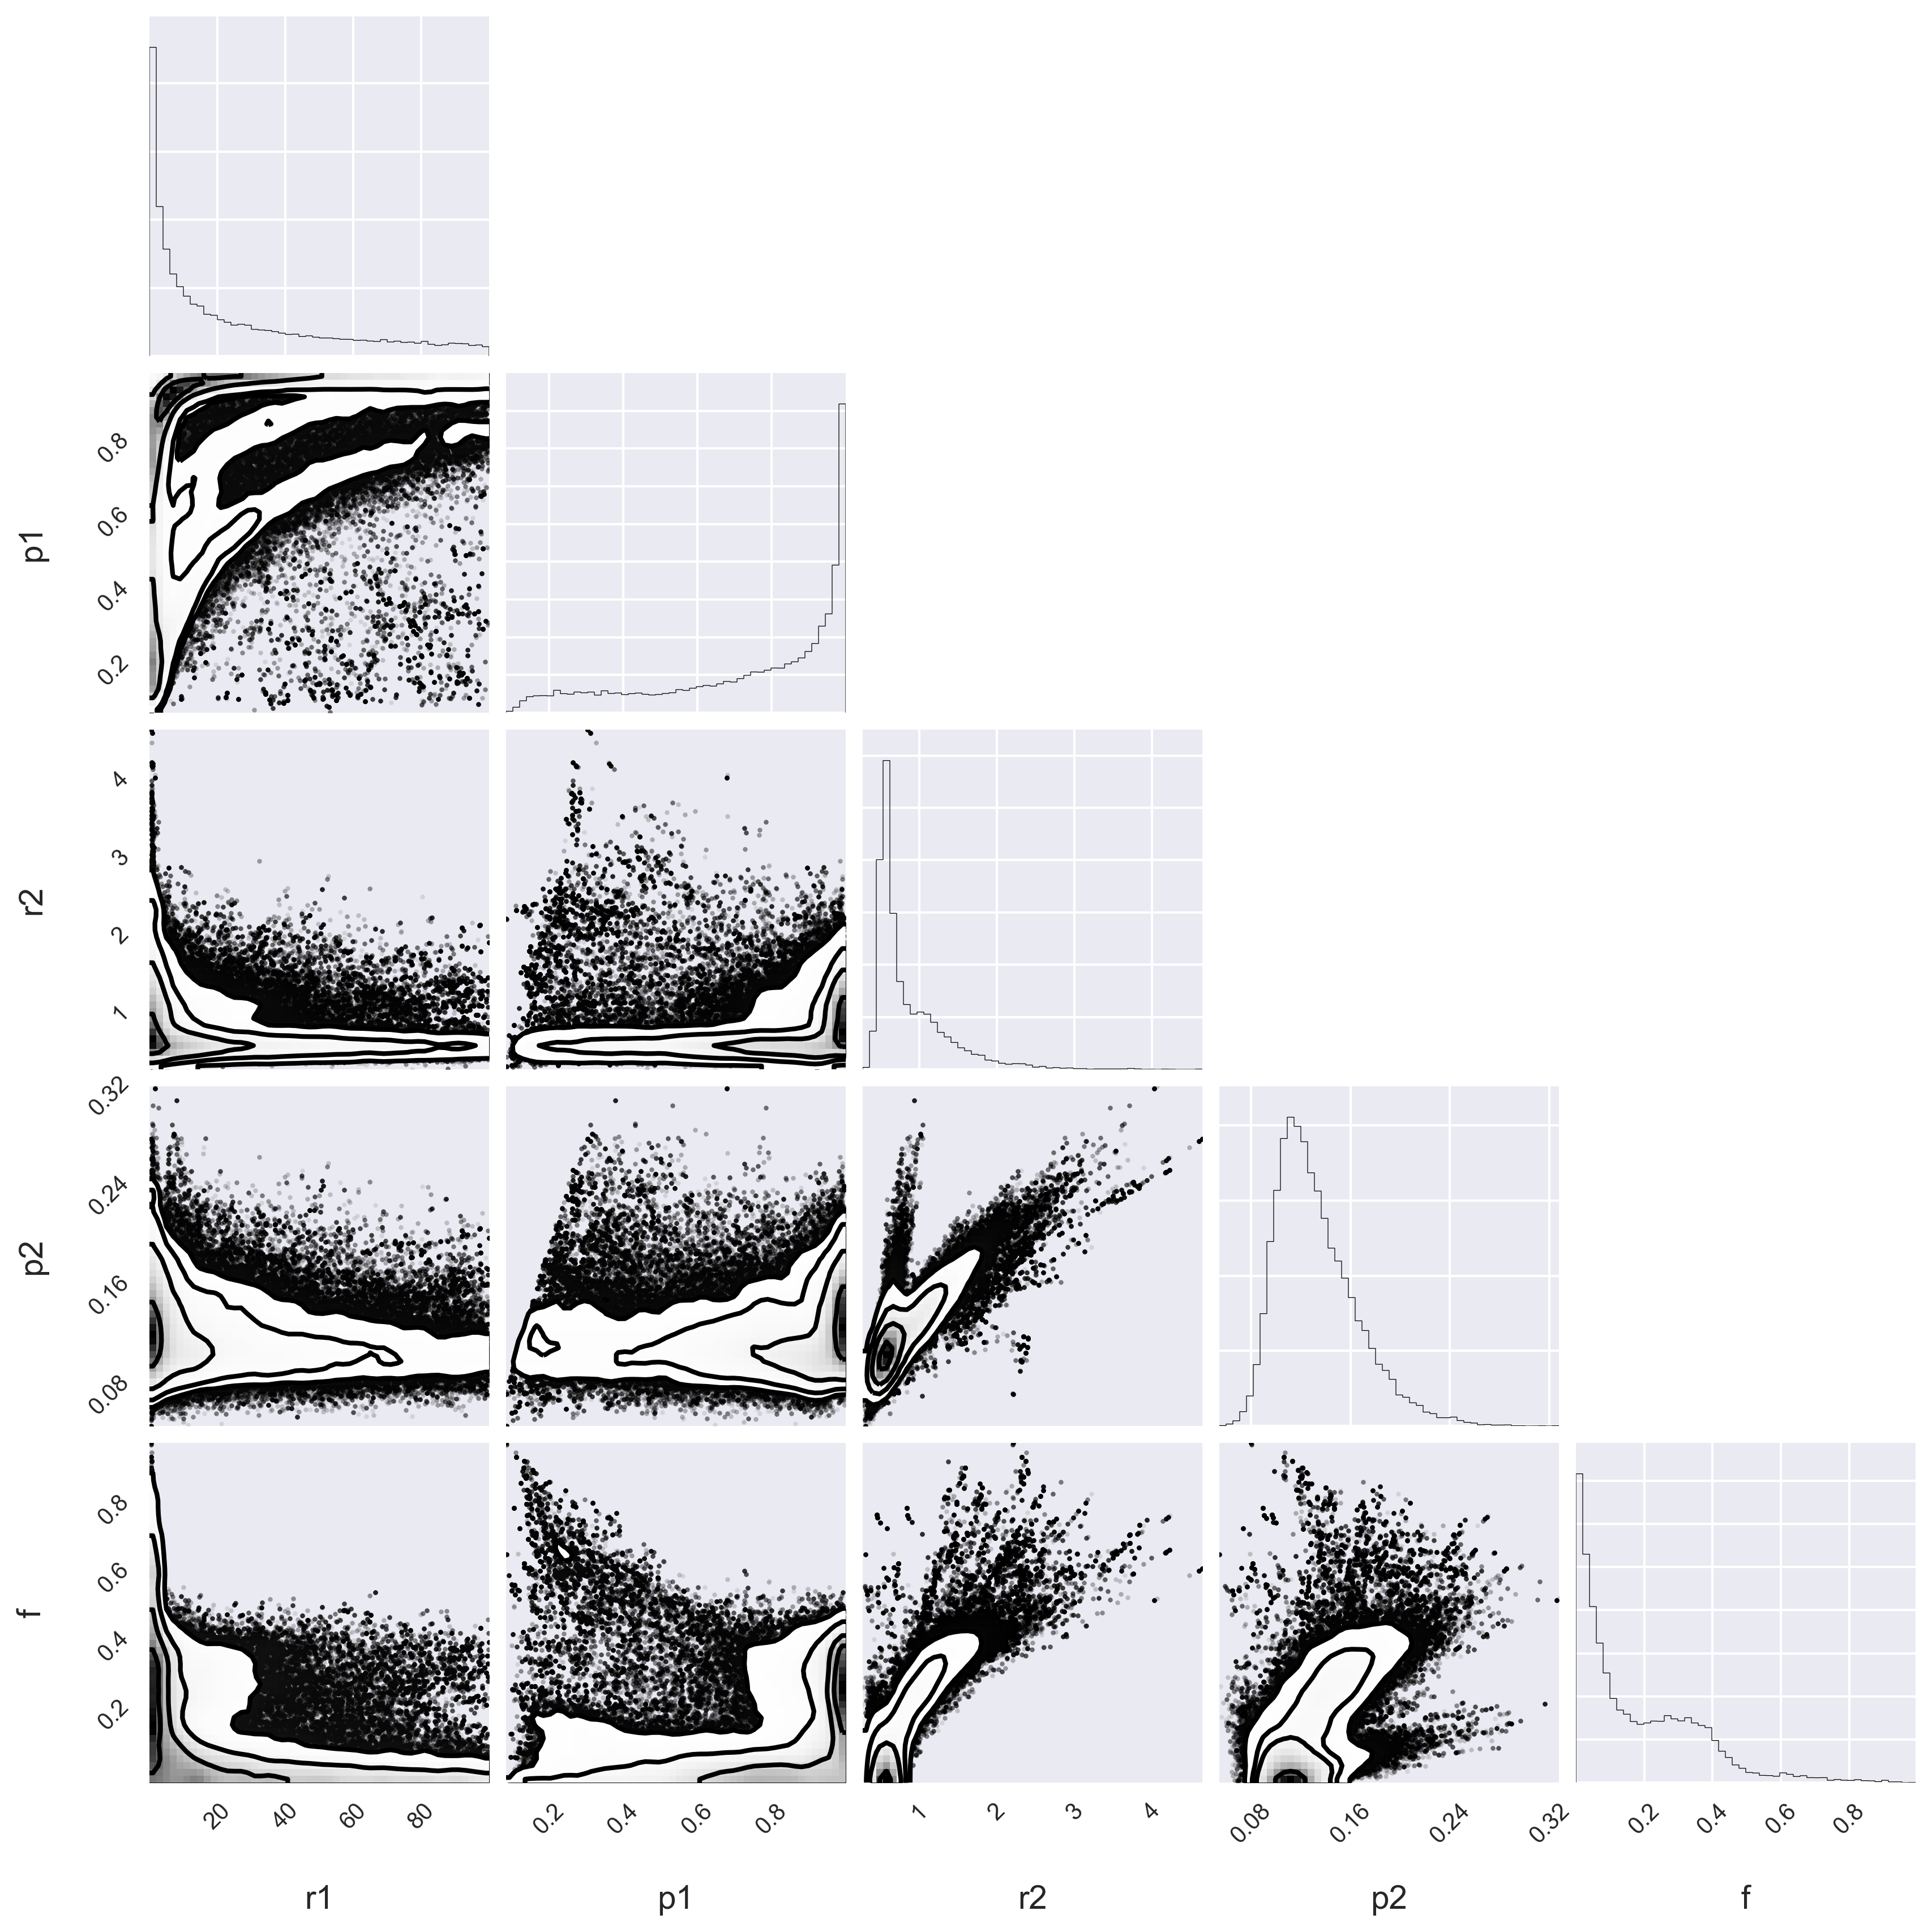

In [21]:
corner.corner(df_2[df_2.columns[:-2]], labels=df_2.columns[:-2], bins=50, 
              smooth=1);

Wow, these things are nowhere near Gaussian.  Therefore, the approximation for the odds ratio breaks down.  We will learn in [the next tutorial](t6b_ptmcmc.html) how to compute the odds ratio using PTMCMC without approximation.  We will then be able to make the comparison.